# Multivariate Drift Detection with PCA

This notebook demonstrates **Multivariate Drift** detection using Principal Component Analysis (PCA). Unlike univariate drift detection, this approach captures changes in the **correlation structure** between features, not just individual feature distributions.

## Key Concept
When features are correlated, PCA can compress data efficiently. If correlations change in production, reconstruction error increases - signaling multivariate drift.

### Step 1: Import Libraries

We import NumPy for numerical computation and PCA from scikit-learn for dimensionality reduction.

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Step 2: Generate Training Data (Correlated Features)

We create training data with **highly correlated** features (correlation = 0.9). This represents the baseline data distribution the model was trained on.

In [2]:
np.random.seed(42)

# Training data with high correlation (0.9) between features
train_mean = [0, 0]
train_cov = [
    [1.0, 0.9],
    [0.9, 1.0]
]

X_train = np.random.multivariate_normal(
    mean=train_mean,
    cov=train_cov,
    size=1000
)

print(f"Training data shape: {X_train.shape}")
print(f"Training correlation: {np.corrcoef(X_train.T)[0, 1]:.4f}")

Training data shape: (1000, 2)
Training correlation: 0.8892


### Step 3: Generate Production Data (Correlation Changed)

We create production data with **weakly correlated** features (correlation = 0.2). This simulates a real-world scenario where the relationship between features has changed.

In [3]:
# Production data with low correlation (0.2) between features
prod_mean = [0, 0]
prod_cov = [
    [1.0, 0.2],
    [0.2, 1.0]
]

X_prod = np.random.multivariate_normal(
    mean=prod_mean,
    cov=prod_cov,
    size=1000
)

print(f"Production data shape: {X_prod.shape}")
print(f"Production correlation: {np.corrcoef(X_prod.T)[0, 1]:.4f}")

Production data shape: (1000, 2)
Production correlation: 0.2051


### Step 4: Visualize Data Distributions

We plot scatter plots to visualize the difference in correlation structure between training and production data.

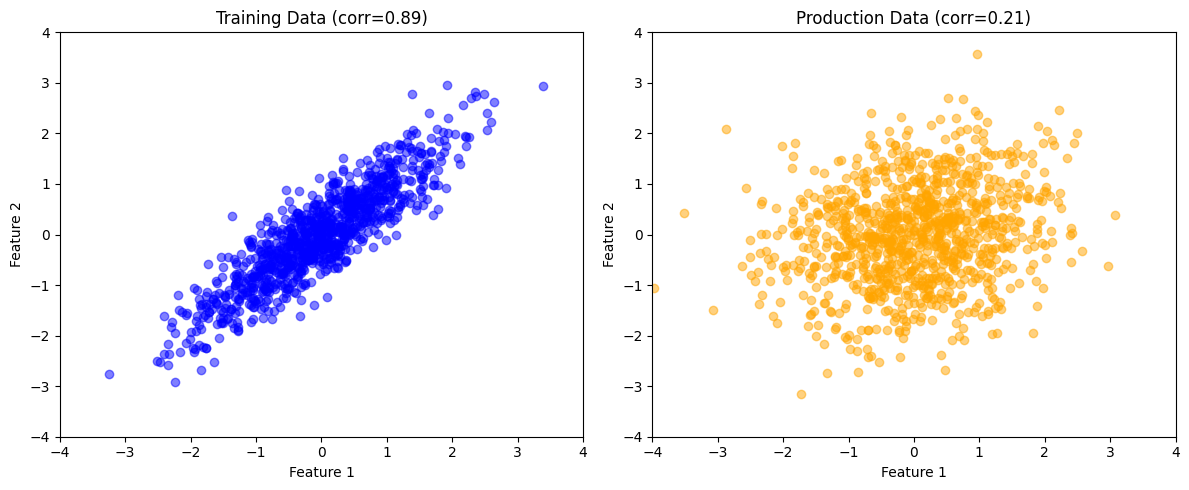

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training data
axes[0].scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, c='blue')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title(f'Training Data (corr={np.corrcoef(X_train.T)[0,1]:.2f})')
axes[0].set_xlim(-4, 4)
axes[0].set_ylim(-4, 4)

# Production data
axes[1].scatter(X_prod[:, 0], X_prod[:, 1], alpha=0.5, c='orange')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title(f'Production Data (corr={np.corrcoef(X_prod.T)[0,1]:.2f})')
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(-4, 4)

plt.tight_layout()
plt.show()

### Step 5: Fit PCA on Training Data

We fit PCA with 1 component on training data. Since features are highly correlated, one component captures most variance. This becomes our baseline for detecting drift.

In [5]:
# Fit PCA on training data only
pca = PCA(n_components=1)
pca.fit(X_train)

print(f"Explained variance ratio: {pca.explained_variance_ratio_[0]:.4f}")
print(f"Principal component: {pca.components_[0]}")

Explained variance ratio: 0.9446
Principal component: [0.70757665 0.7066366 ]


### Step 6: Calculate Reconstruction Error

We transform data to PCA space and back. The reconstruction error measures how much information is lost. Higher error = correlation structure has changed.

In [6]:
# Transform and reconstruct training data
X_train_transformed = pca.transform(X_train)
X_train_recon = pca.inverse_transform(X_train_transformed)

# Transform and reconstruct production data
X_prod_transformed = pca.transform(X_prod)
X_prod_recon = pca.inverse_transform(X_prod_transformed)

# Calculate mean reconstruction error (L2 norm)
train_error = np.mean(np.linalg.norm(X_train - X_train_recon, axis=1))
prod_error = np.mean(np.linalg.norm(X_prod - X_prod_recon, axis=1))

print(f"Training Reconstruction Error: {train_error:.4f}")
print(f"Production Reconstruction Error: {prod_error:.4f}")
print(f"Error Ratio (Prod/Train): {prod_error / train_error:.4f}")

Training Reconstruction Error: 0.2572
Production Reconstruction Error: 0.7201
Error Ratio (Prod/Train): 2.7998


### Step 7: Detect Multivariate Drift

We apply a threshold-based detection: if production error exceeds training error by more than 20%, we flag multivariate drift.

In [7]:
# Drift detection threshold
DRIFT_THRESHOLD = 1.2  # 20% increase

error_ratio = prod_error / train_error

print("=" * 50)
print("MULTIVARIATE DRIFT DETECTION RESULTS")
print("=" * 50)
print(f"Train Reconstruction Error: {train_error:.4f}")
print(f"Prod Reconstruction Error:  {prod_error:.4f}")
print(f"Error Ratio:                {error_ratio:.4f}")
print(f"Threshold:                  {DRIFT_THRESHOLD}")
print("=" * 50)

if error_ratio > DRIFT_THRESHOLD:
    print("🚨 MULTIVARIATE DRIFT DETECTED")
    print("   The correlation structure between features has changed!")
else:
    print("✅ No Multivariate Drift Detected")
    print("   Feature correlations remain stable.")

MULTIVARIATE DRIFT DETECTION RESULTS
Train Reconstruction Error: 0.2572
Prod Reconstruction Error:  0.7201
Error Ratio:                2.7998
Threshold:                  1.2
🚨 MULTIVARIATE DRIFT DETECTED
   The correlation structure between features has changed!


### Step 8: Visualize Reconstruction Errors

We plot the distribution of reconstruction errors for training and production data to visualize the drift.

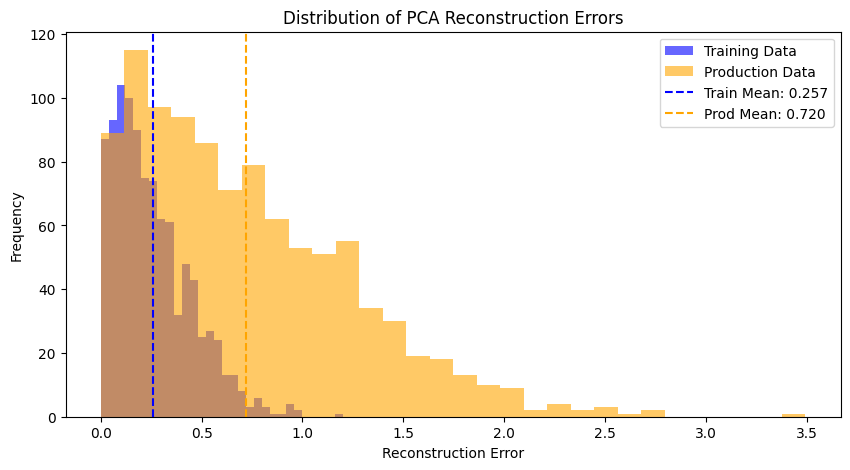

In [8]:
# Calculate individual reconstruction errors
train_errors = np.linalg.norm(X_train - X_train_recon, axis=1)
prod_errors = np.linalg.norm(X_prod - X_prod_recon, axis=1)

plt.figure(figsize=(10, 5))
plt.hist(train_errors, bins=30, alpha=0.6, label='Training Data', color='blue')
plt.hist(prod_errors, bins=30, alpha=0.6, label='Production Data', color='orange')
plt.axvline(train_error, color='blue', linestyle='--', label=f'Train Mean: {train_error:.3f}')
plt.axvline(prod_error, color='orange', linestyle='--', label=f'Prod Mean: {prod_error:.3f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of PCA Reconstruction Errors')
plt.legend()
plt.show()

---

## Summary

| Metric | Training | Production |
|--------|----------|------------|
| Feature Correlation | 0.9 (high) | 0.2 (low) |
| Reconstruction Error | Low | High |
| Drift Status | Baseline | **DRIFT DETECTED** |

### Key Takeaways

1. **PCA captures correlation**: Highly correlated features compress well; broken correlations don't.
2. **Reconstruction error as metric**: Increased error signals structural changes in data.
3. **Complementary to univariate tests**: This catches drift that KS-tests on individual features might miss.
4. **Threshold tuning**: The 1.2x threshold should be calibrated based on your use case.